In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# uncomment to disable numba
# os.environ['NOJIT'] = 'true'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import pprint
from njit_multisymbol import *
from procedures import utc_ms, load_live_config, fetch_market_specific_settings, make_get_filepath
from pure_funcs import (
    date_to_ts2,
    ts_to_date_utc,
    tuplify,
    numpyize,
    stats_multi_to_df,
    fills_multi_to_df,
    calc_drawdowns,
    calc_sharpe_ratio,
    analyze_fills_multi,
)
from njit_funcs import round_dynamic
from plotting import plot_fills_multi, plot_pnls_long_short, plot_pnls_separate, plot_pnls_stuck
from numba import njit
from downloader import load_hlc_cache, prepare_multsymbol_data

using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

### multi symbol backtest with lossless auto unstuck

- if a position is stuck, bot will use profits made on other markets to realize losses for the stuck position
- if multiple positions are stuck, select the stuck pos whose price action distance is the lowest
- each live config's individual auto unstuck is disabled

In [4]:
# select symbols for multi symbol backtest
symbols = ['ADAUSDT', 'ATOMUSDT', 'ETCUSDT', 'LINKUSDT', 'ONTUSDT', 'VETUSDT', 'XRPUSDT', 'XTZUSDT']
symbols = tuple(symbols)
lcs = [
    load_live_config(f"configs/live/single_symbol_optimizations/recursive_grid/{symbol}.json")
    for symbol in symbols
]

TWE_long = 2.0  # WE_limit for each symbol will be TWE / len(symbols)
TWE_short = 1.0  # WE_limit for each symbol will be TWE / len(symbols)


for i in range(len(lcs)):
    lcs[i]["long"]["wallet_exposure_limit"] = TWE_long / len(symbols)
    lcs[i]["short"]["wallet_exposure_limit"] = TWE_short / len(symbols)
    

# convert configs to numpy matrix
live_configs = numpyize([live_config_dict_to_list_recursive_grid(lc) for lc in lcs])

In [5]:
start_date = "2019-01-01"
end_date = "now"
cache_fname = make_get_filepath("tmp/" + "_".join(symbols) + "_hlc_cache.npy")
# prepare_multsymbol_data() is computationally expensive, so use a cache
try:
    hlcs = np.load(cache_fname)
    first_ts = 0
except:
    first_ts, hlcs = await prepare_multsymbol_data(symbols, start_date, end_date)
    np.save(cache_fname, hlcs)

In [6]:
starting_balance = 10000.0
do_longs = tuplify([True for _ in range(len(symbols))])
do_shorts = tuplify([True for _ in range(len(symbols))])

cache_fname_mss = make_get_filepath("tmp/" + "_".join(symbols) + "_market_specific_settings.json")
try:
    mss = json.load(open(cache_fname_mss))
except:
    mss = [
        fetch_market_specific_settings(
            {"symbol": symbol, "exchange": "binance", "market_type": "futures"}
        )
        for symbol in symbols
    ]
    json.dump(mss, open(cache_fname_mss, 'w'))
maker_fee = mss[0]["maker_fee"]

qty_steps = tuplify([mss[i]["qty_step"] for i in range(len(symbols))])
price_steps = tuplify([mss[i]["price_step"] for i in range(len(symbols))])
min_costs = tuplify([mss[i]["min_cost"] for i in range(len(symbols))])
min_qtys = tuplify([mss[i]["min_qty"] for i in range(len(symbols))])
c_mults = tuplify([mss[i]["c_mult"] for i in range(len(symbols))])

In [7]:
hlcs_clipped = hlcs # [:,0:60000] # to backtest on subset on data

In [8]:
# will compile JIT on the first run, then be faster on subsequent runs
sts = utc_ms()
res = backtest_multisymbol_recursive_grid(
    hlcs_clipped,
    starting_balance,
    maker_fee,
    do_longs,
    do_shorts,
    c_mults,
    symbols,
    qty_steps,
    price_steps,
    min_costs,
    min_qtys,
    live_configs,
)
print(f"time elapsed {(utc_ms() - sts) / 1000:.6f}s")
fills, stats = res

time elapsed 94.931724s


In [9]:
fdf = fills_multi_to_df(fills, symbols, c_mults)
sdf = stats_multi_to_df(stats, symbols)

In [10]:
params = {'TWE_long': TWE_long, 'TWE_short': TWE_short}
analysis = analyze_fills_multi(sdf, fdf, params)

In [11]:
mkl = max([len(k) for k in analysis])
for k, v in analysis.items():
    if isinstance(v, dict):
        continue
        mkls = max([len(s) for s in v])
        for symbol in v:
            mkl1 = max([len(k) for k in v[symbol]])
            for k1, v1 in v[symbol].items():
                print(f"    {symbol: <{mkls}} {k1: <{mkl1}} {round_dynamic(v1, 6)}")
            print()
    else:
        print(f"{k: <{mkl}} {round_dynamic(v, 6)}")
pd.DataFrame({k: v for k, v in analysis["individual_analyses"].items()})

n_days                     1405.67
starting_balance           10000.0
final_balance              738480.0
final_equity               706522.0
drawdown_max               0.79376
mean_of_10_worst_drawdowns 0.188402
adg                        0.00331684
pnl_sum                    801903.0
pnl_long                   693816.0
pnl_short                  108087.0
sum_profit_long            985547.0
sum_loss_long              -291732.0
loss_profit_ratio_long     0.29601
sum_profit_short           417720.0
sum_loss_short             -309633.0
loss_profit_ratio_short    0.741245


,ADAUSDT,ATOMUSDT,ETCUSDT,LINKUSDT,ONTUSDT,VETUSDT,XRPUSDT,XTZUSDT
pnl_ratio,0.0706864406,0.1753474080,0.0625571500,0.1025470283,0.1472000526,0.1644483667,0.1187966246,0.1584169292
pnl_long,67555.9144857526,89773.7541739821,89967.0094405003,87823.7492341443,57414.2022995080,123992.4447373183,87164.0645551997,90124.6585434072
pnl_short,-10872.2440971901,50837.8623580510,-39802.2417406766,-5590.9772636940,60625.9648120751,7879.1975982487,8099.3077653783,36910.3557889353
sum_profit_long,184943.0639964763,89974.1204286245,157231.2204888181,165918.3173828512,59326.4002736225,126998.1311755845,96193.8627490725,104962.2157507528
sum_loss_long,-117387.1495107237,-200.3662546424,-67264.2110483178,-78094.5681487068,-1912.1979741145,-3005.6864382662,-9029.7981938727,-14837.5572073456
loss_profit_ratio_long,0.6347204754,0.0022269321,0.4278044198,0.4706808108,0.0322318220,0.0236671706,0.0938708347,0.1413609374
sum_profit_short,41729.4524157131,82600.8052935469,47531.1688469766,37887.8299688527,71737.6333711496,46831.9268765655,25946.0540350561,63455.2732257935
sum_loss_short,-52601.6965129032,-31762.9429354958,-87333.4105876531,-43478.8072325468,-11111.6685590746,-38952.7292783168,-17846.7462696778,-26544.9174368582
loss_profit_ratio_short,1.2605412597,0.3845355118,1.8373924460,1.1475665740,0.1548931577,0.8317558528,0.6878404803,0.4183248466
stuck_time_ratio_long,0.1290074292,0.0016626585,0.0699289611,0.0783072842,0.0016923990,0.0261893174,0.0061135632,0.0120593970


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

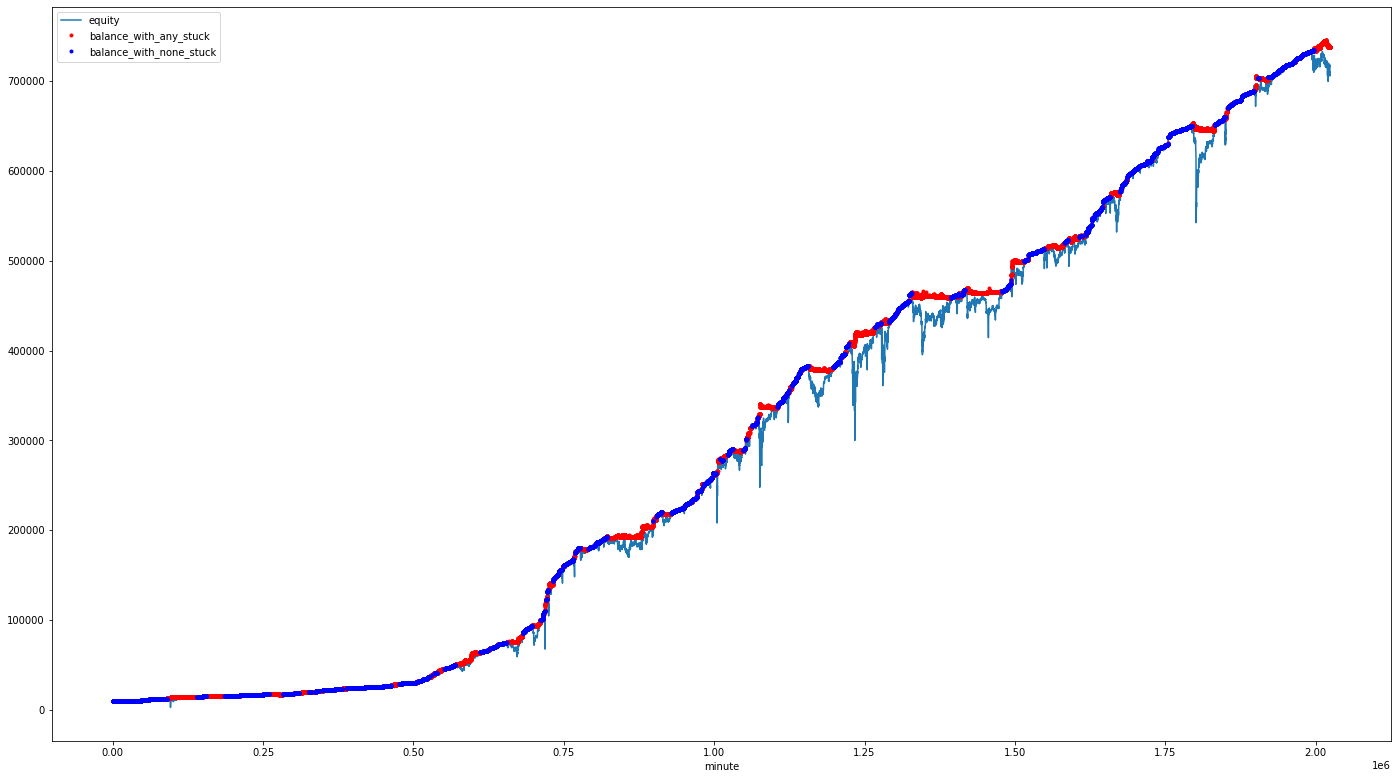

In [12]:
plot_pnls_stuck(sdf, fdf)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

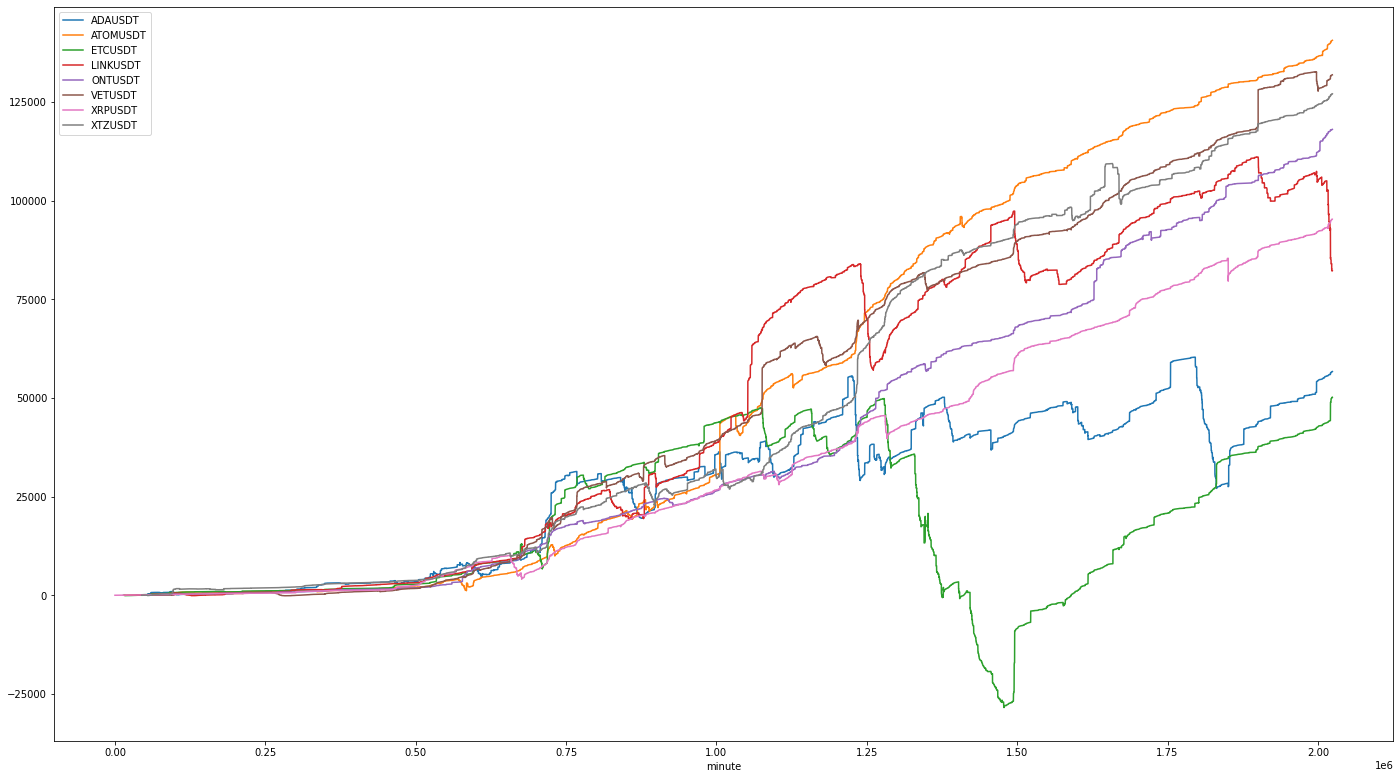

In [13]:
plot_pnls_separate(sdf, fdf)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

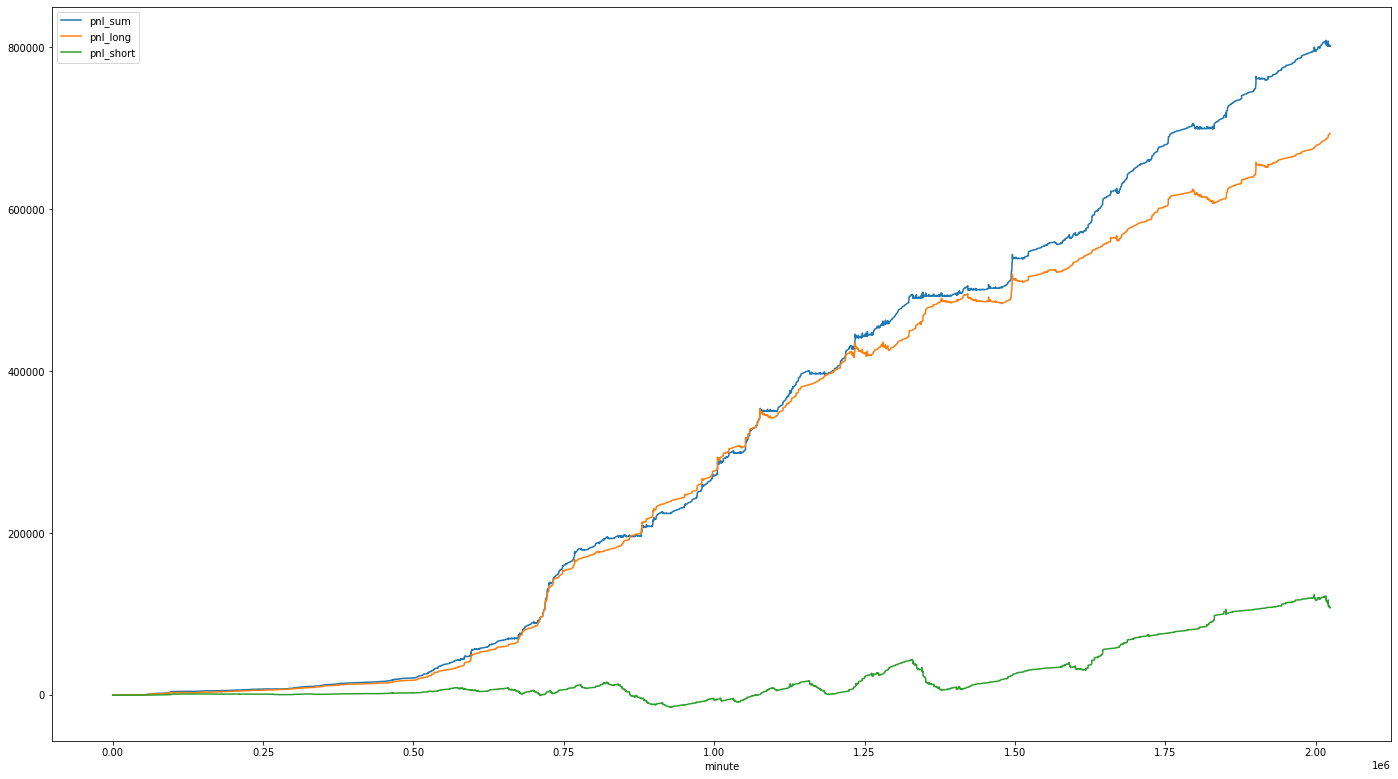

In [14]:
plot_pnls_long_short(sdf, fdf)

<AxesSubplot:xlabel='minute'>

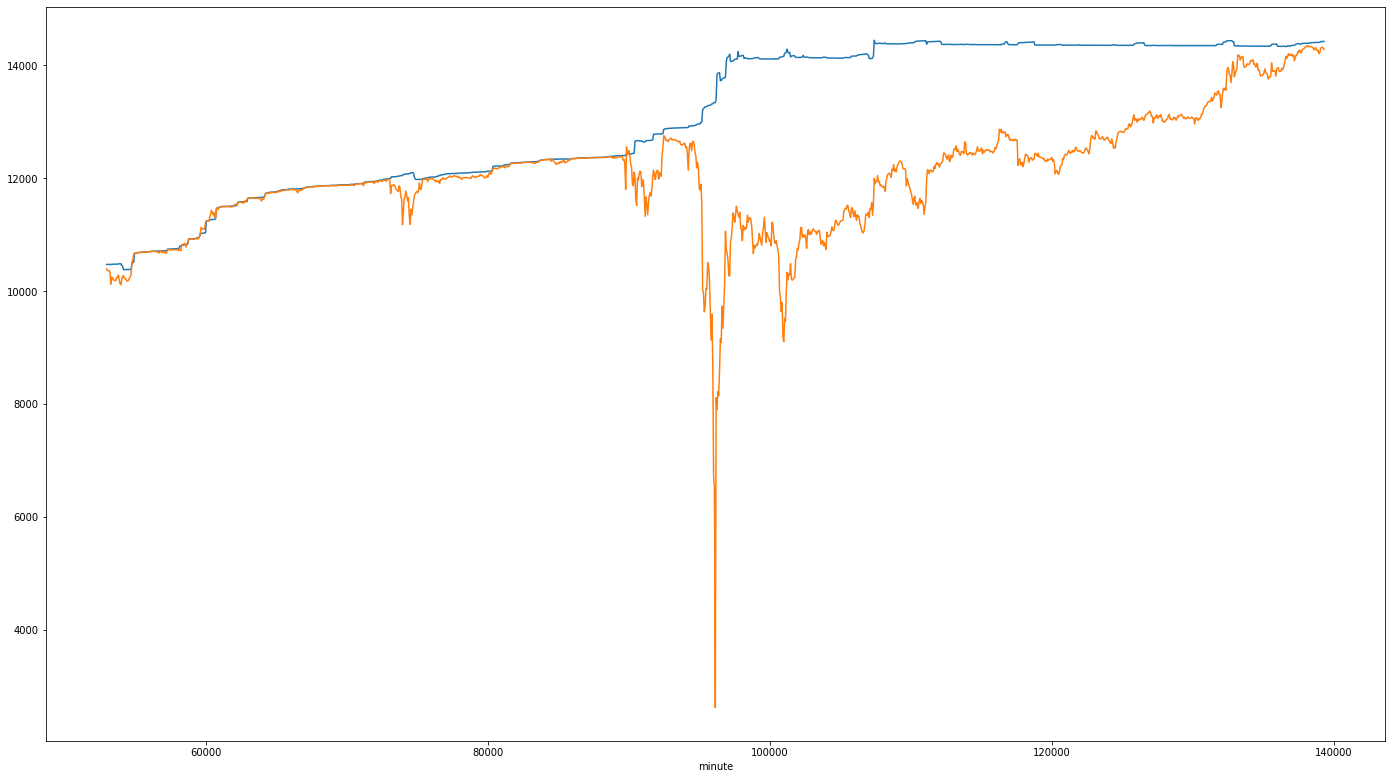

In [15]:
# inspect one month before and one month after location of worst drawdown
drawdowns = calc_drawdowns(sdf.equity)
worst_drawdown_loc = drawdowns.sort_values().iloc[:1].index[0]
wdls = worst_drawdown_loc - 60 * 24 * 30
wdle = worst_drawdown_loc + 60 * 24 * 30
sdfc = sdf.loc[wdls:wdle]
sdfc.balance.plot()
sdfc.equity.plot()

ADAUSDT


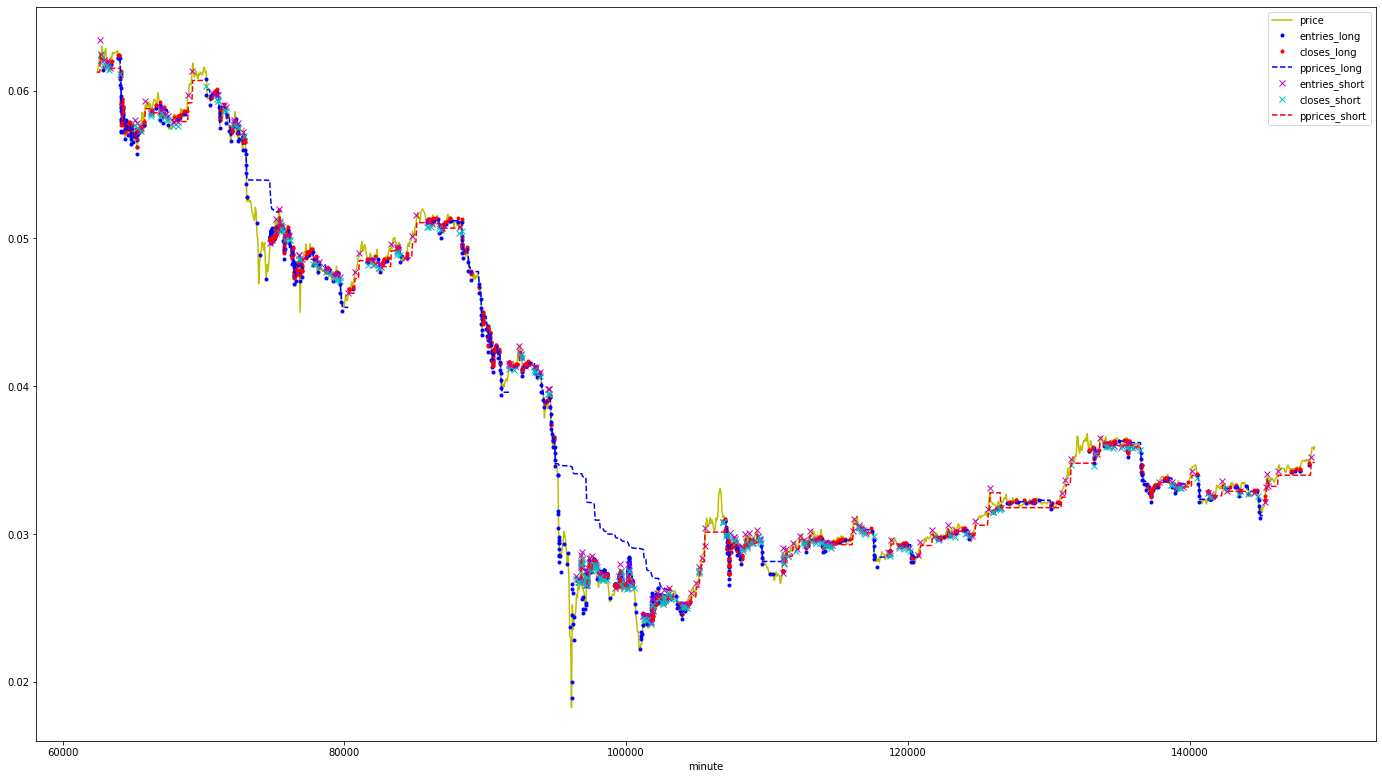

ATOMUSDT


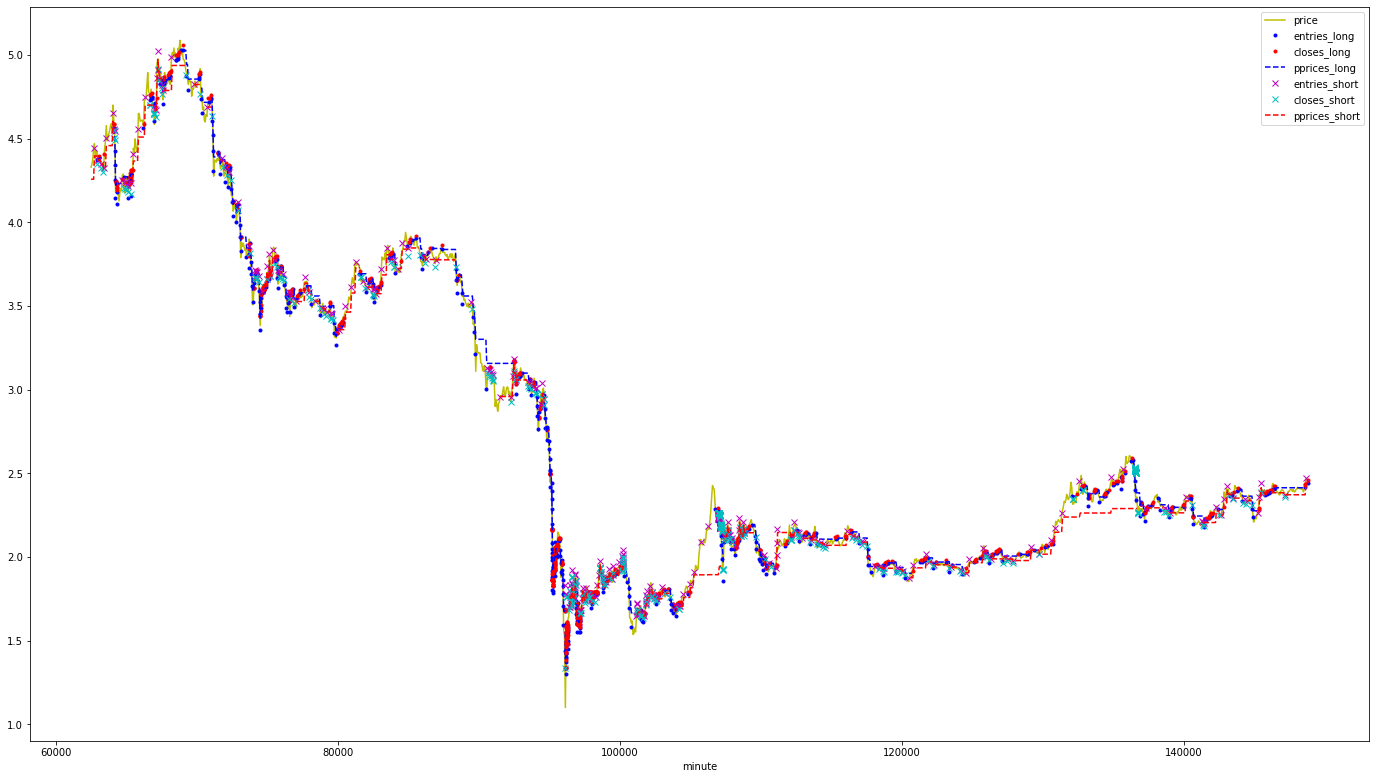

ETCUSDT


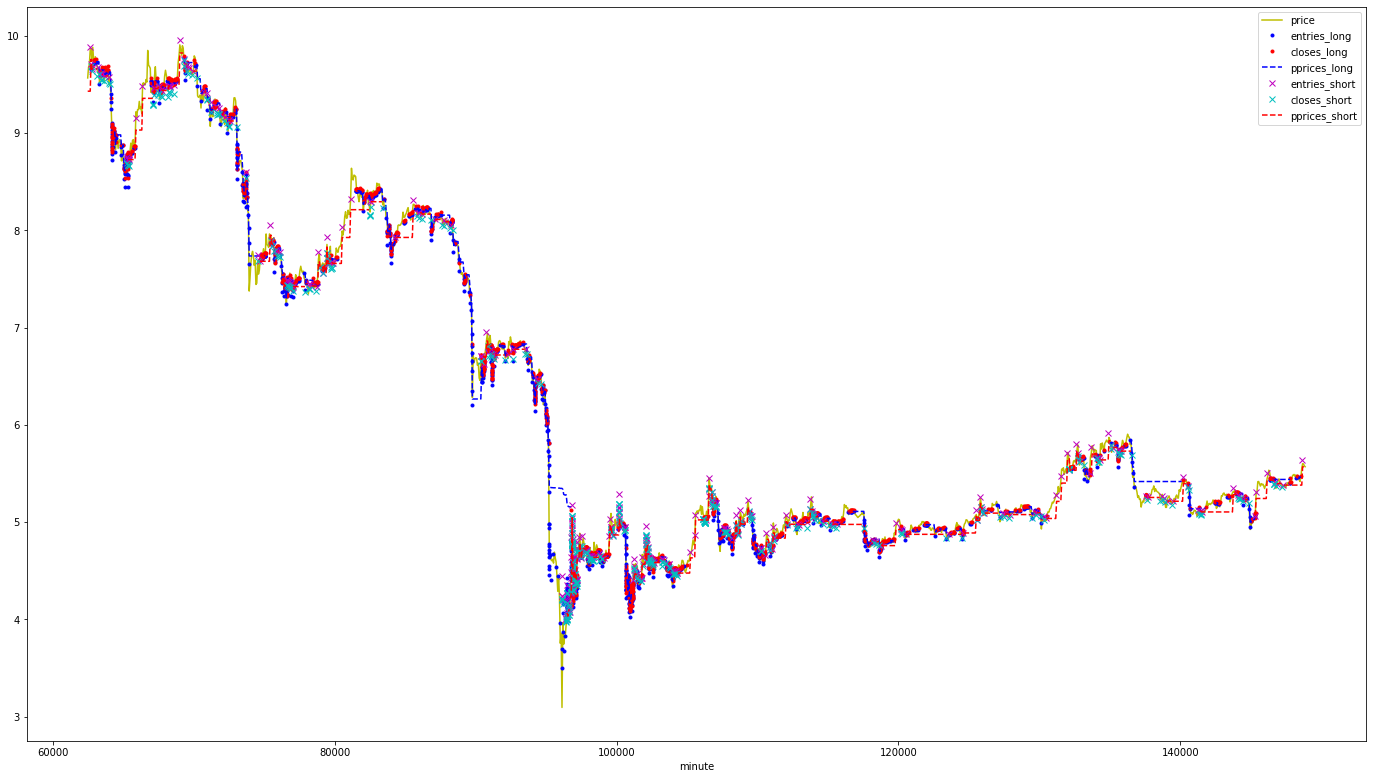

LINKUSDT


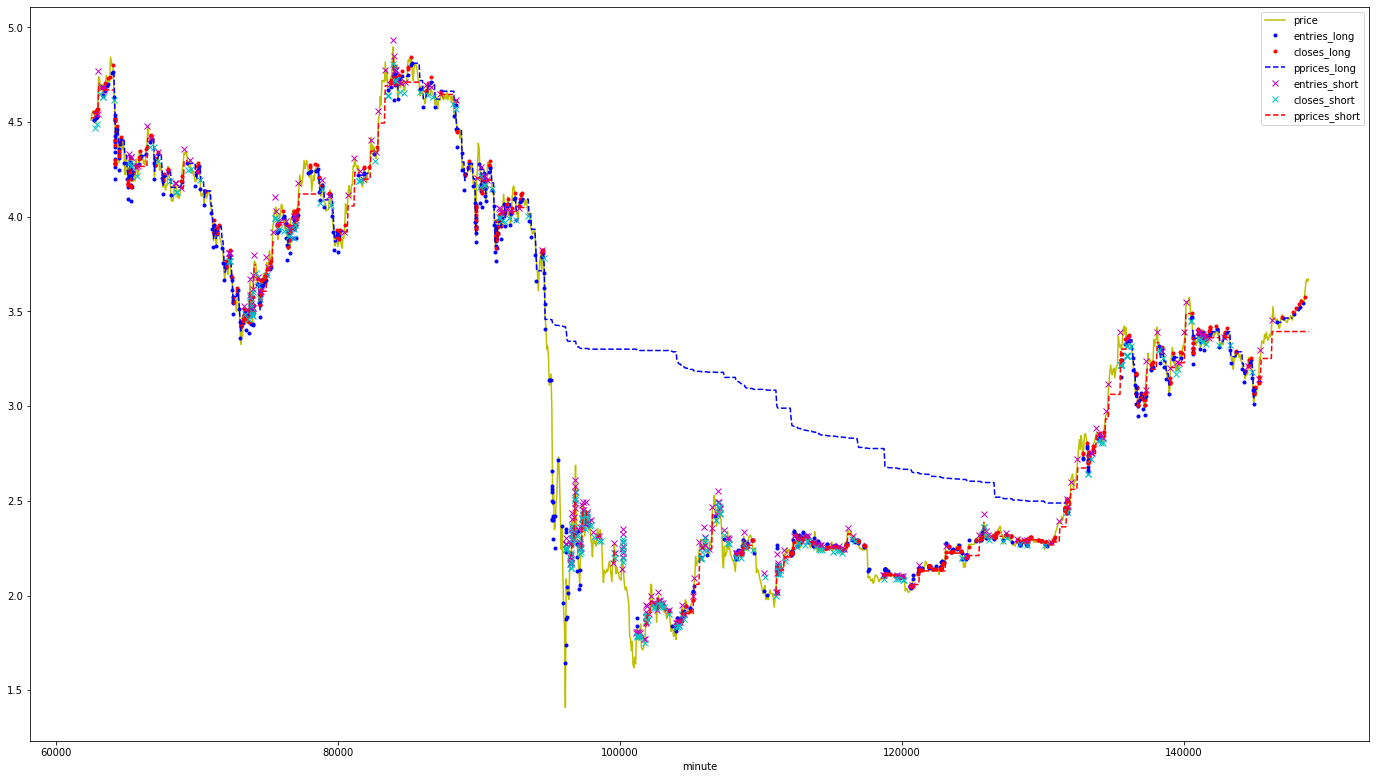

ONTUSDT


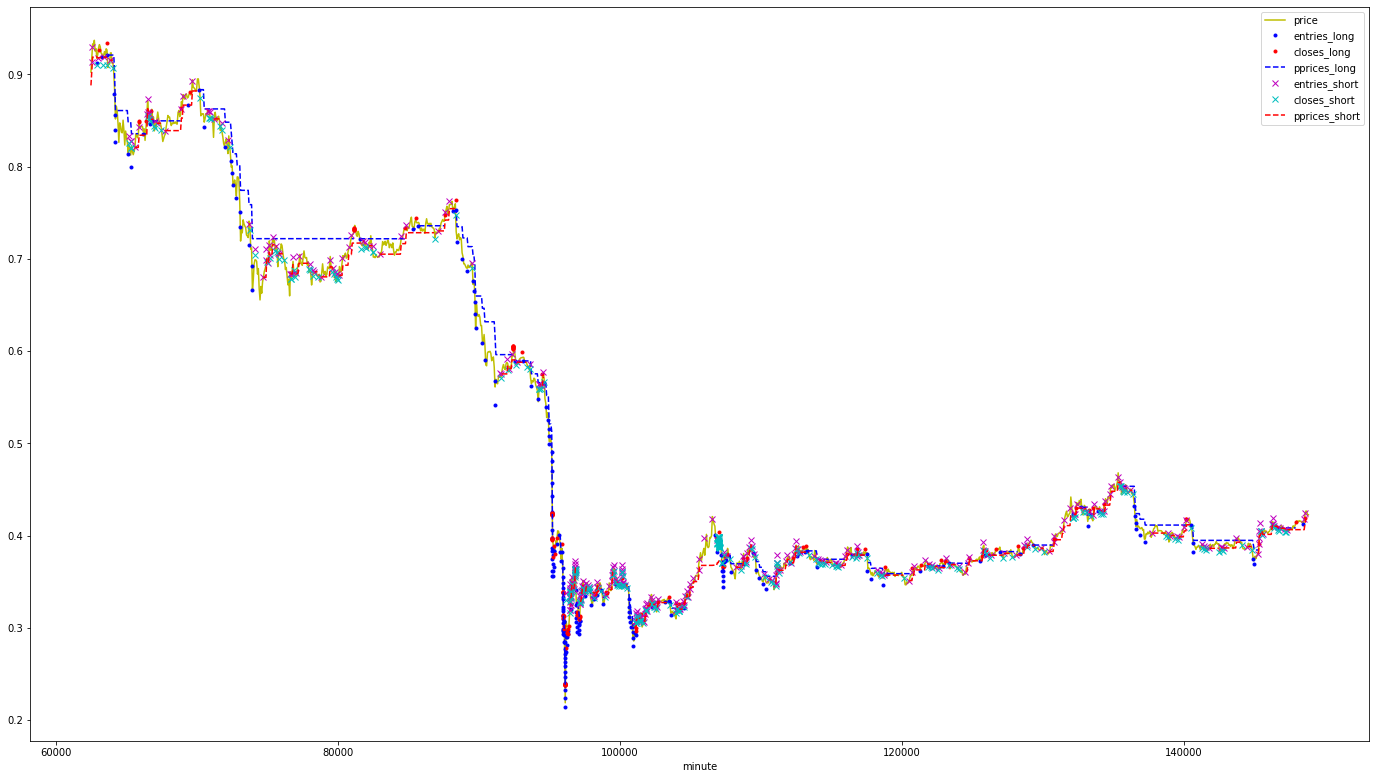

VETUSDT


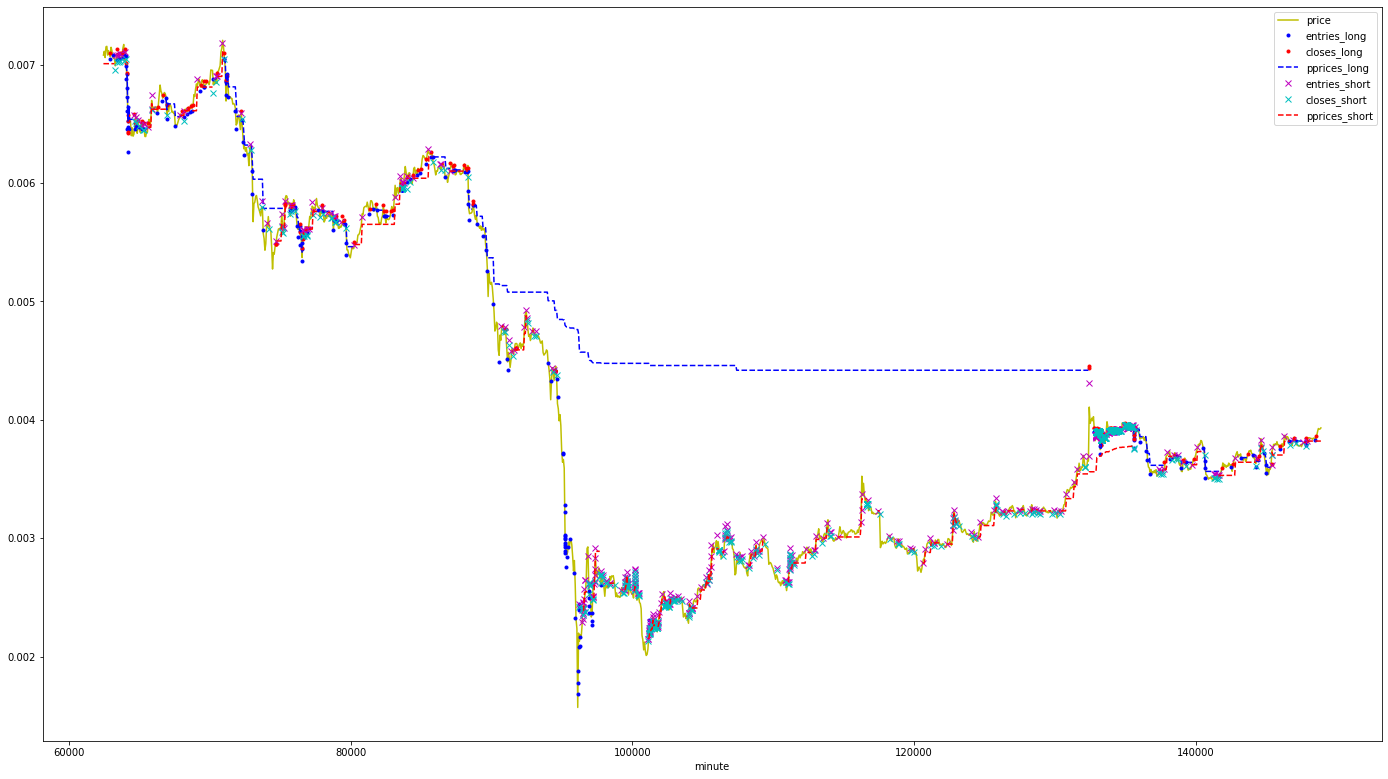

XRPUSDT


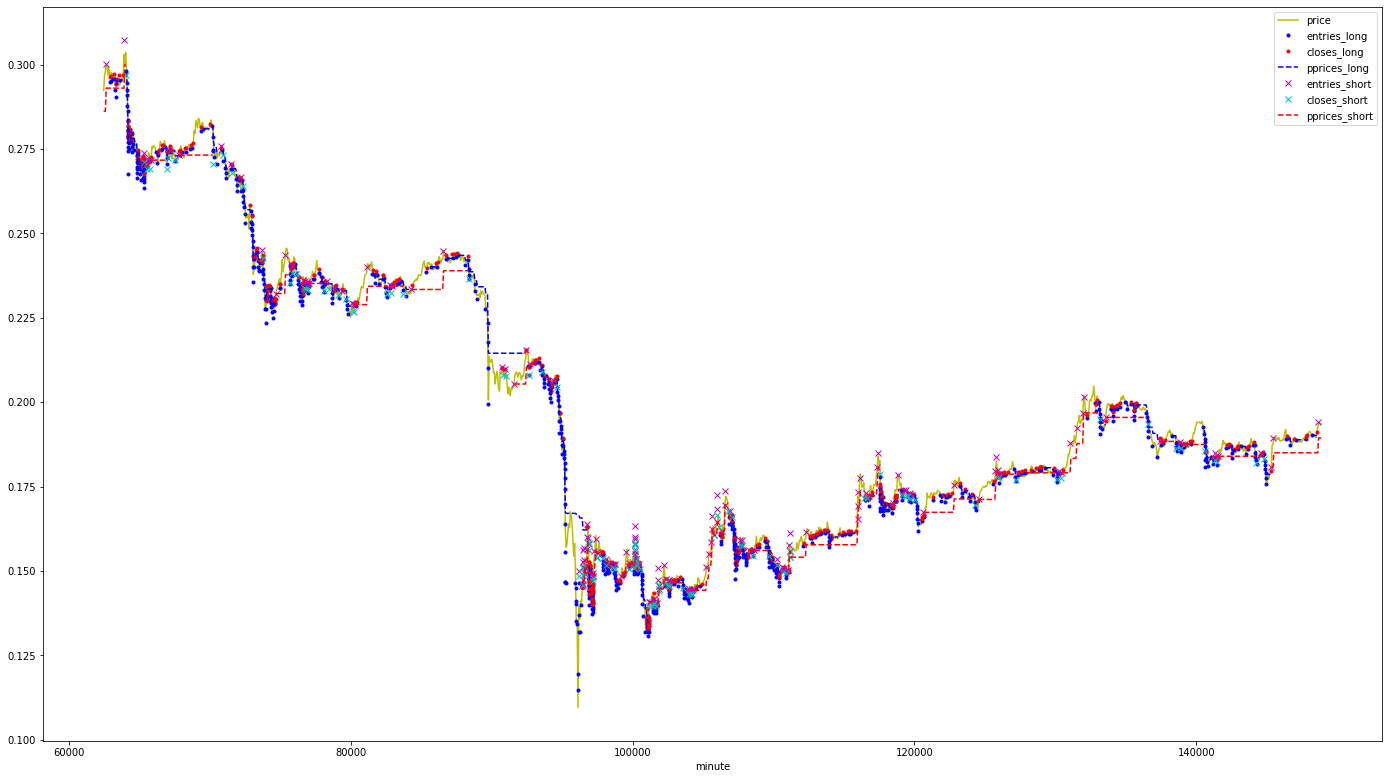

XTZUSDT


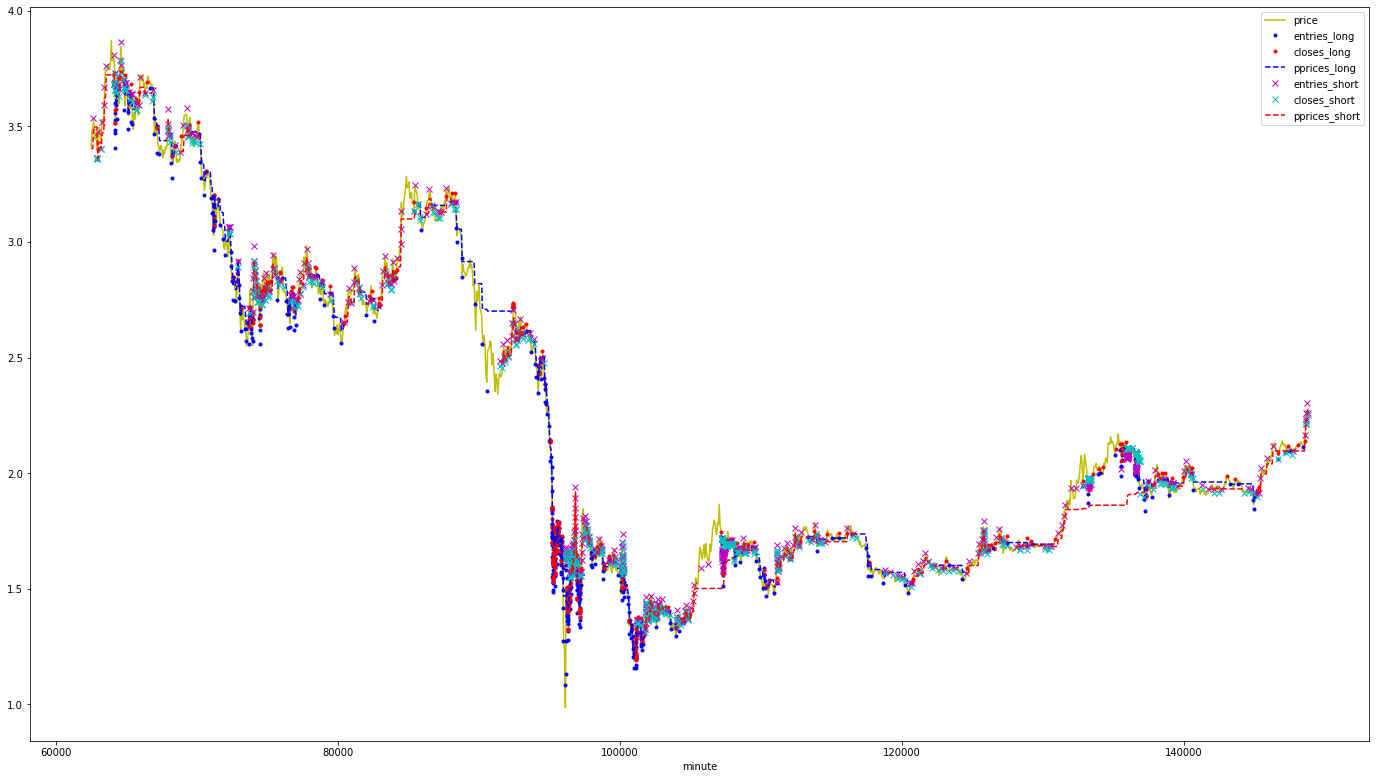

In [21]:
# inspect for each symbol
for symbol in symbols:
    print(symbol)
    plot_fills_multi(symbol, sdf.loc[wdls:wdle], fdf.loc[wdls:wdle]).show()

<AxesSubplot:xlabel='minute'>

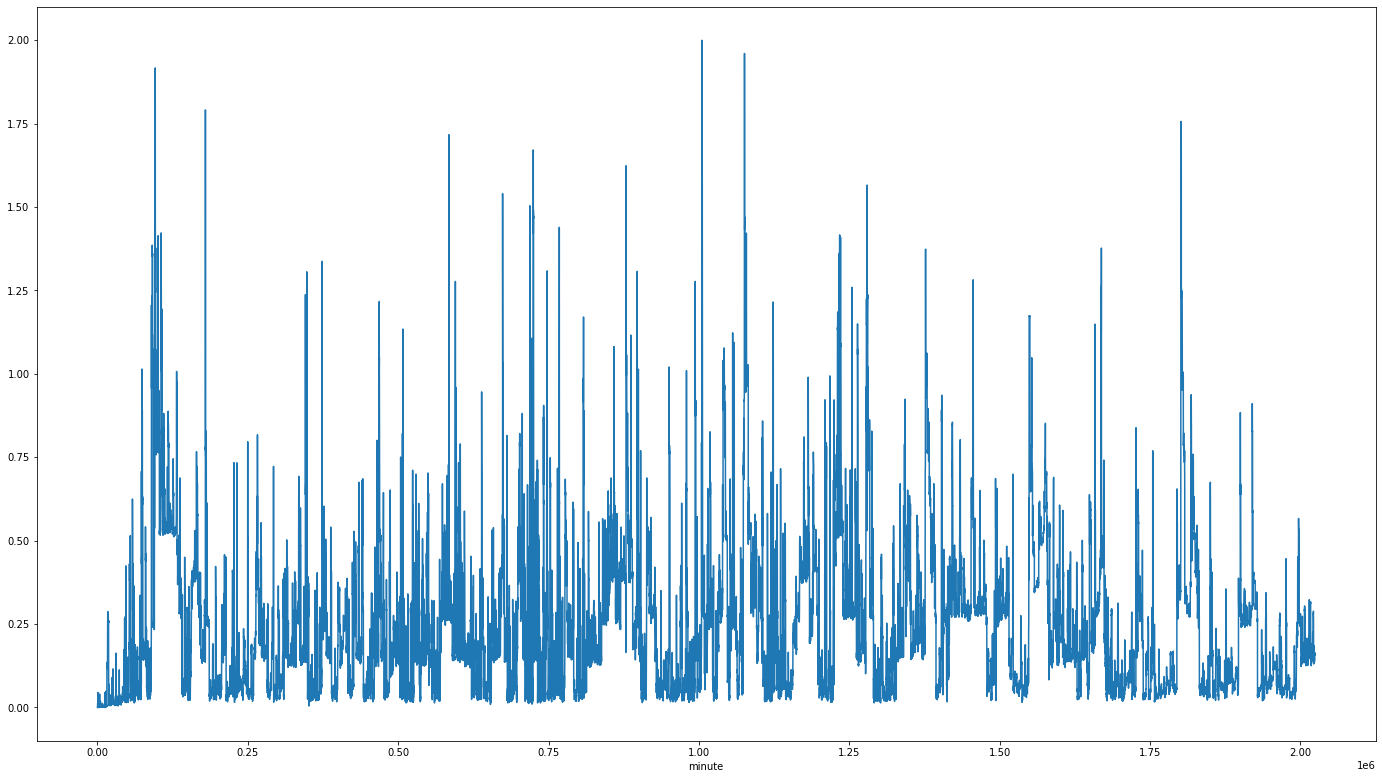

In [17]:
# exposures
sdf[[c for c in sdf.columns if "WE" in c]].sum(axis=1).plot()

In [18]:
higest_WE_loc_long = sdf[[c for c in sdf.columns if "WE_l" in c]].sum(axis=1).idxmax()
higest_WE_loc_short = sdf[[c for c in sdf.columns if "WE_s" in c]].sum(axis=1).idxmax()
higest_WE_loc_long, higest_WE_loc_short

(1005000, 105660)

<AxesSubplot:xlabel='minute'>

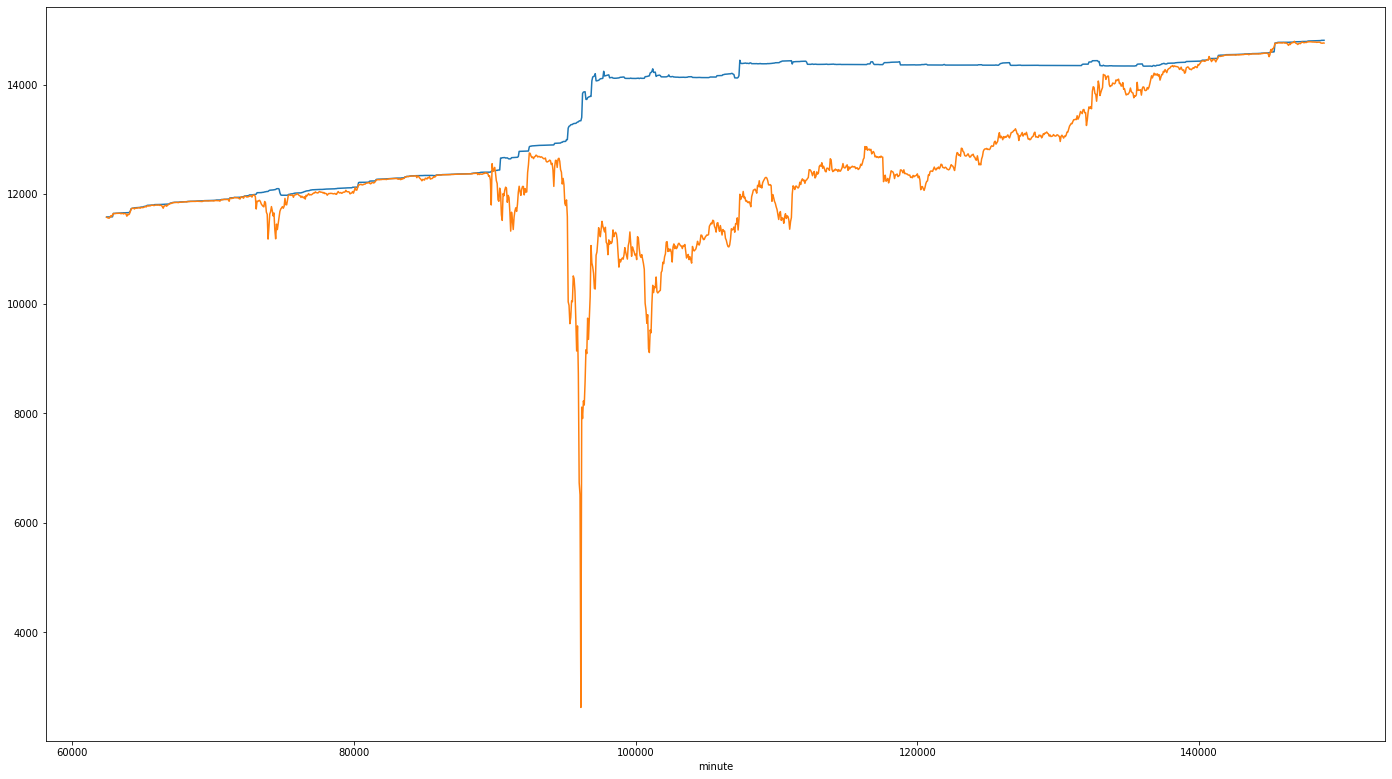

In [19]:
# inspect location of highest total exposure short
wdls = higest_WE_loc_short - 60 * 24 * 30
wdle = higest_WE_loc_short + 60 * 24 * 30
sdfc = sdf.loc[wdls:wdle]

sdfc.balance.plot()
sdfc.equity.plot()